# Final Project - EPL Player Analysis
Skye Kim and Eileen Xu
* Linear Regression
* Logistic Regression
* Neural Networks

In [1]:
import pandas as pd
import numpy as np
import numpy.random as r

from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.feature_selection import SelectKBest, f_regression, chi2
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from pandas.plotting import scatter_matrix
from sklearn.kernel_approximation import RBFSampler

import math

# Visualizing Training Data

Individual features

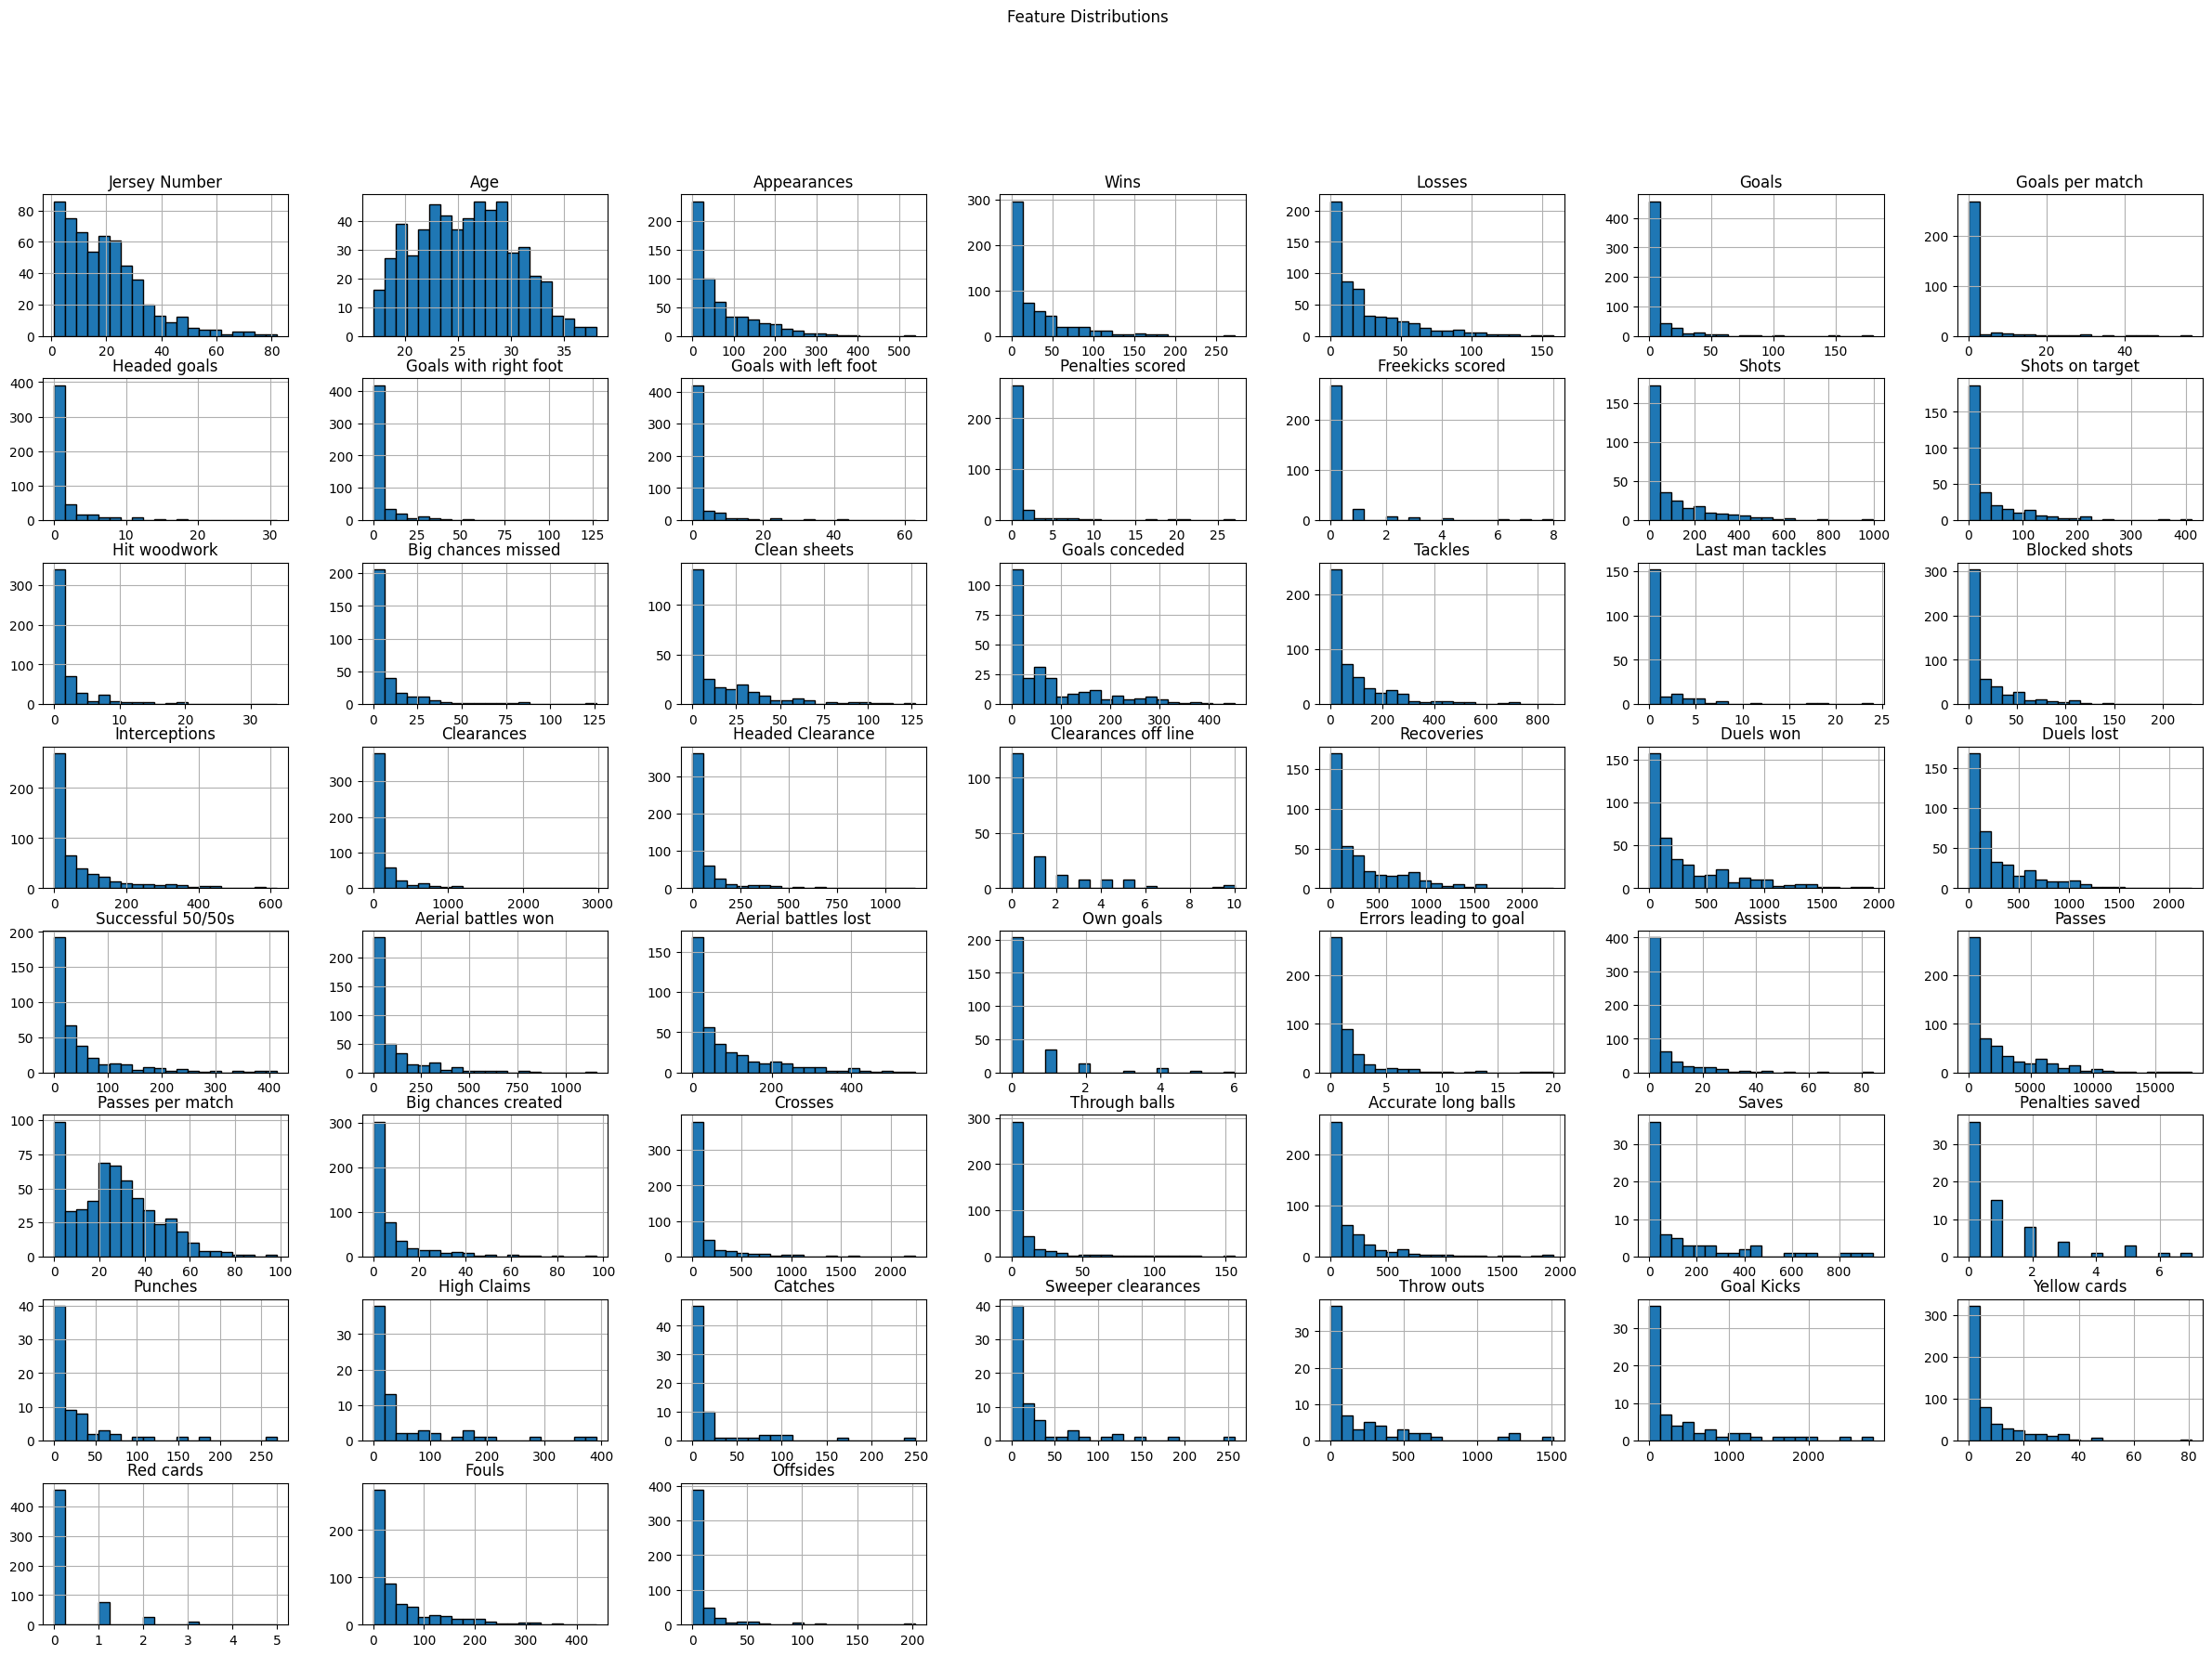

In [2]:
# read data into a pandas dataframe
df = pd.read_csv("epl_dataset.csv")

df.hist(figsize=(30, 20), bins=20, edgecolor='black')
plt.suptitle("Feature Distributions")
plt.show()

Individual features and their relationship with the target variable

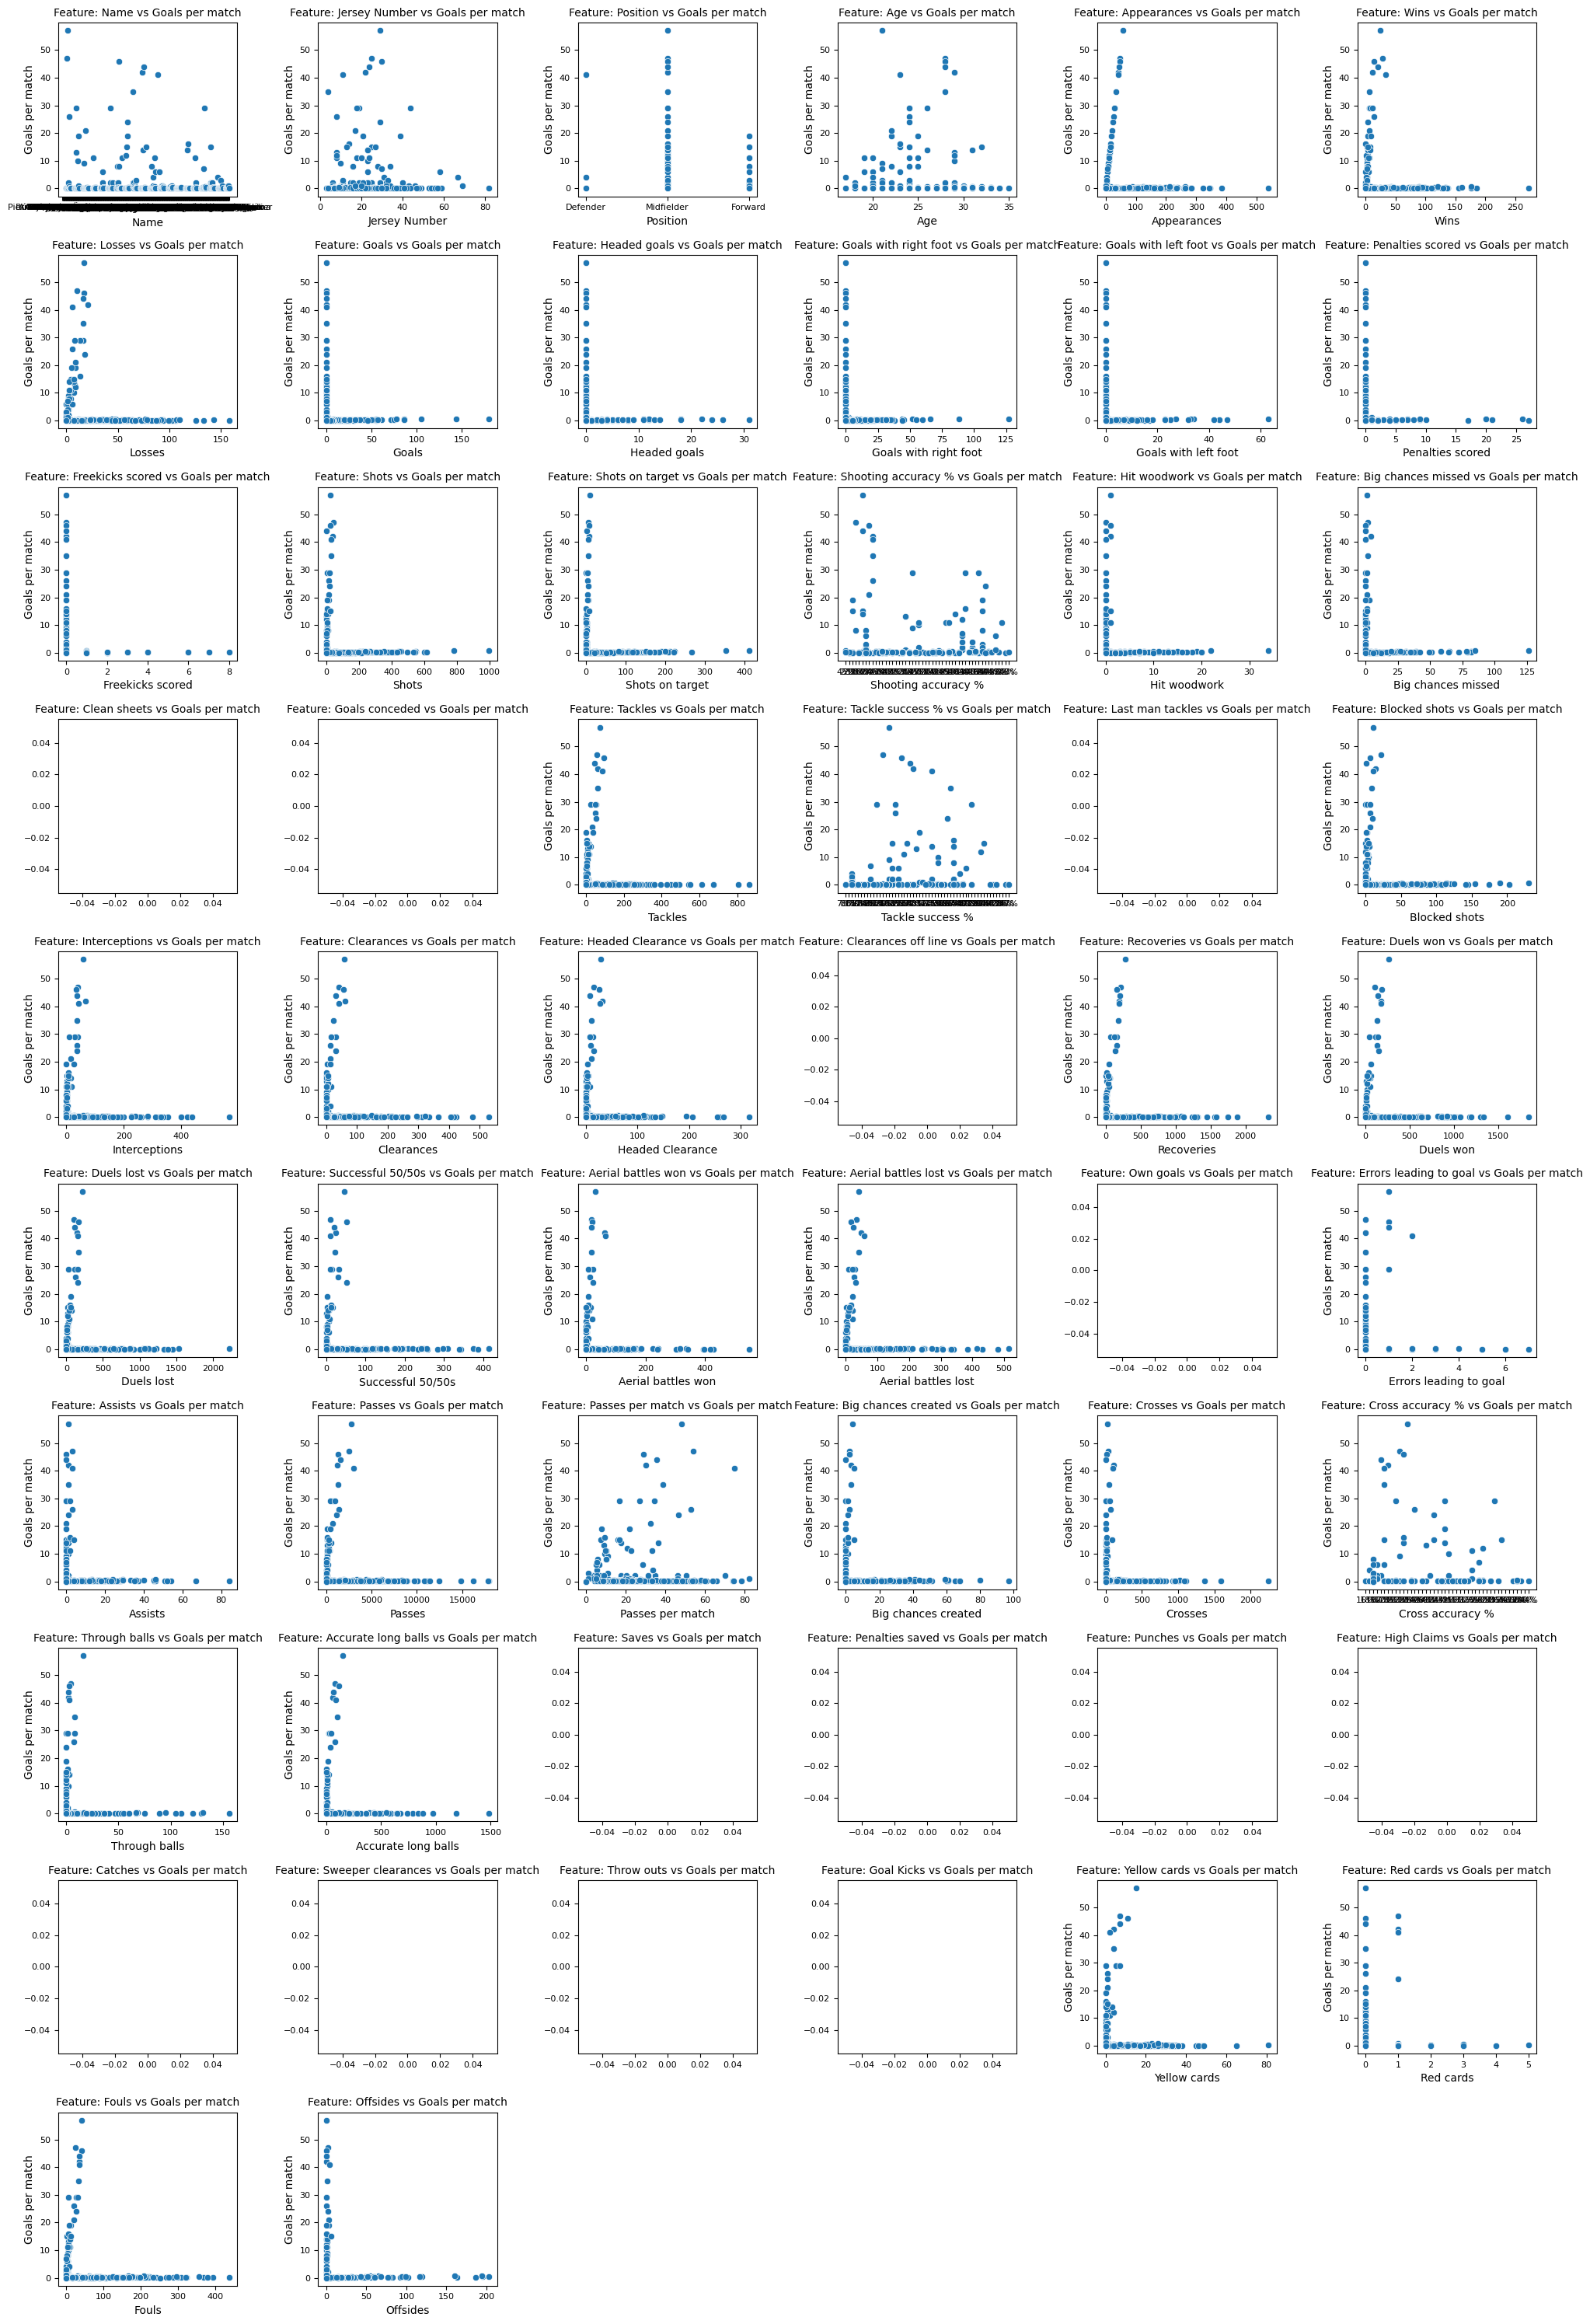

In [ ]:
# exclude "Club" and "Nationality"
filtered_columns = [col for col in df.columns if col != "Goals per match" and not col.startswith("Club") and not col.startswith("Nationality")]

# number of columns and rows in the grid
num_cols = 6
num_rows = math.ceil(len(filtered_columns) / num_cols)

# create the grid of subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, num_rows * 3))
axes = axes.flatten()

# plot each feature
for i, column in enumerate(filtered_columns):
    sns.scatterplot(ax=axes[i], data=df, x=column, y="Goals per match")
    axes[i].set_title(f"Feature: {column} vs Goals per match", fontsize=10)
    axes[i].tick_params(axis='both', which='major', labelsize=8)

# hide unused subplots and adjust layout
for j in range(len(filtered_columns), len(axes)):
    axes[j].axis('off')
plt.tight_layout()
plt.show()

Correlation Matrix

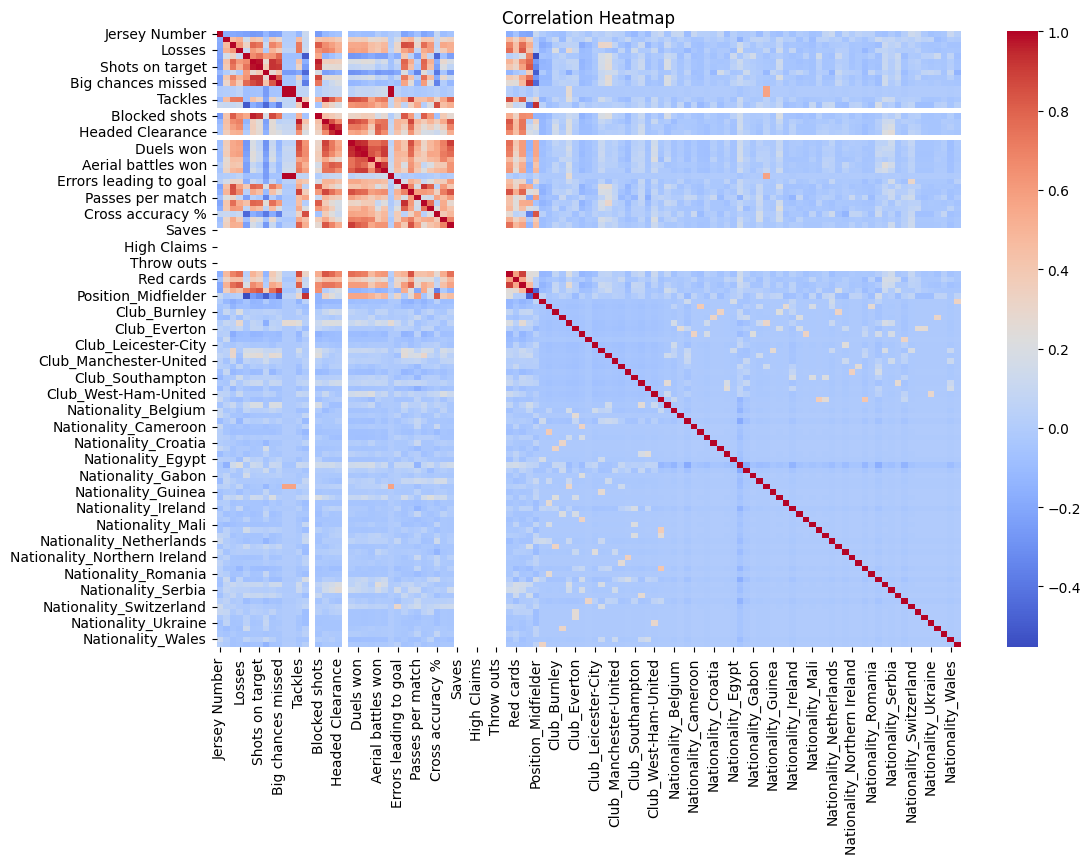

In [ ]:
df_corr = pd.read_csv("epl_dataset.csv")
df_corr = df_corr.drop(['Name'], axis=1)
df_corr = pd.get_dummies(df_corr, columns=['Position', 'Club', 'Nationality',], drop_first=True, dtype=int)
percentage_columns = ['Shooting accuracy %', 'Cross accuracy %', 'Tackle success %']
for column in percentage_columns:
    df_corr[column] = df_corr[column].str.replace('%', '').astype(float) / 100
df_corr.fillna(0, inplace=True)
df_corr['Goals per match'] = df_corr['Goals per match'].apply(lambda x: 0 if x > 1 else x)
df_corr.to_csv("epl_data_corr.csv", index=False)

correlation_matrix = df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=False, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

Clustering and dimensionality

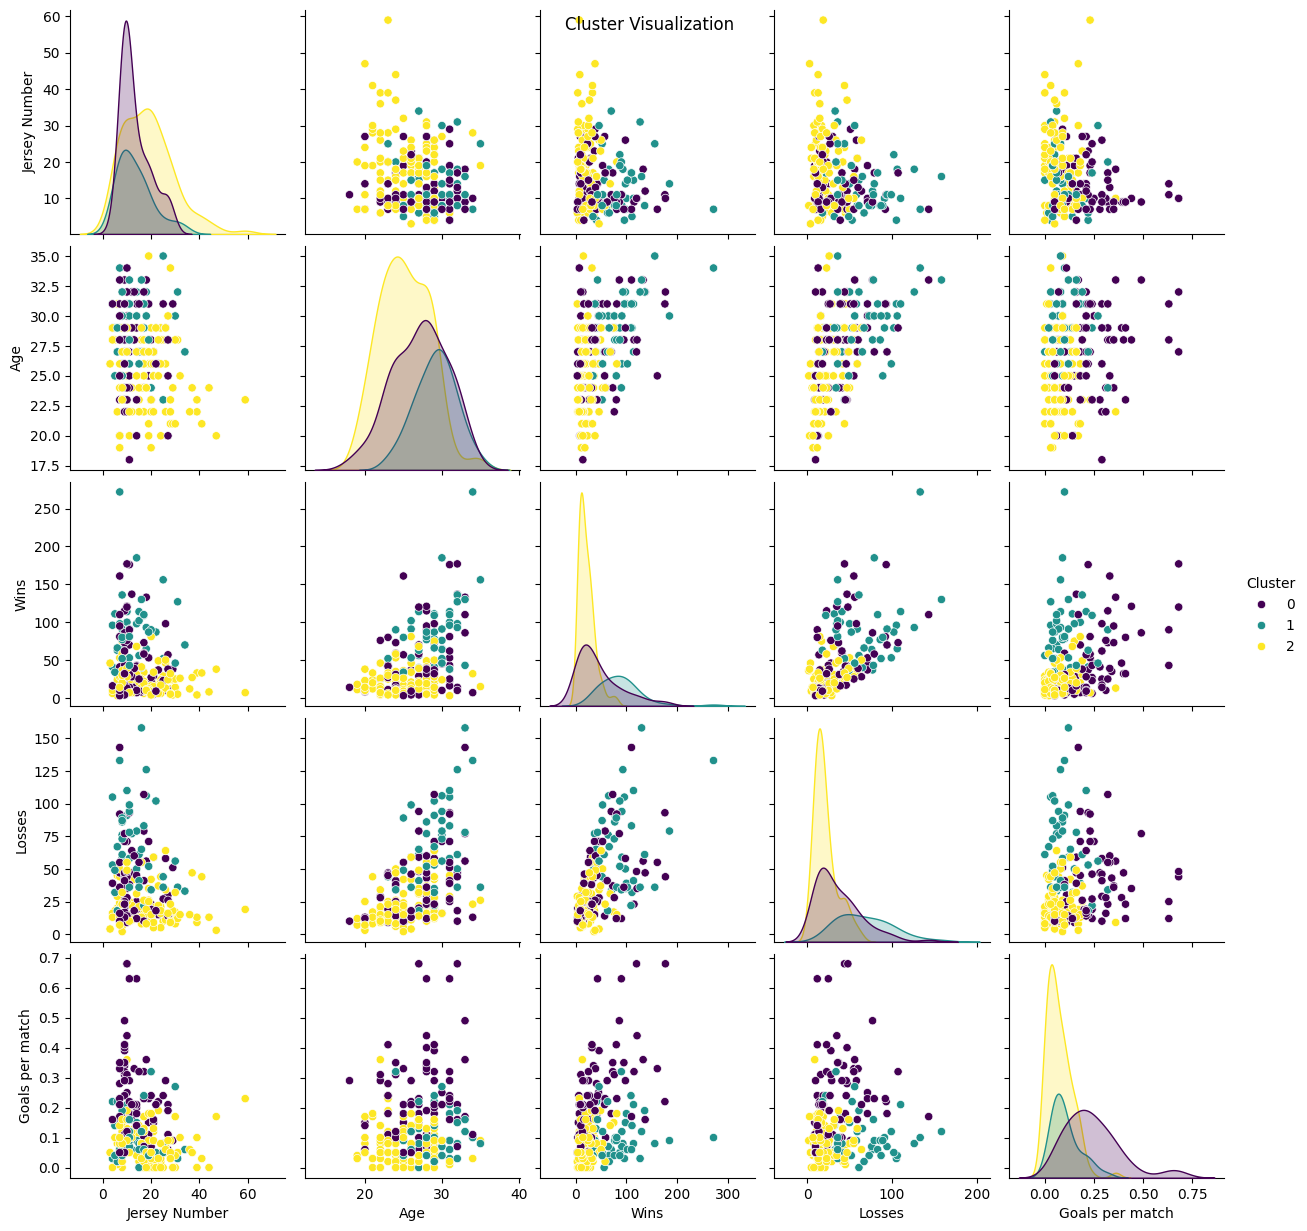

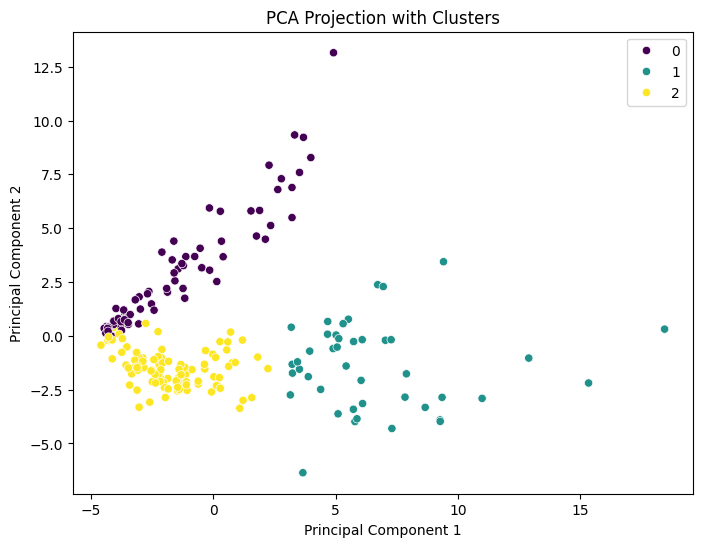

Explained variance ratio: [0.15772333 0.07854294]


In [ ]:
# perform K-Means clustering
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)

X = df.drop(columns=["Goals per match"])
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# choose the optimal number of clusters
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(X_scaled)
df["Cluster"] = kmeans.labels_

# visualize clusters
sns.pairplot(df, vars=df.columns[:5], hue="Cluster", palette="viridis")
plt.suptitle("Cluster Visualization")
plt.show()

# dimensionality reduction (PCA)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# visualize PCA-transformed data
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=kmeans.labels_, palette="viridis")
plt.title("PCA Projection with Clusters")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

# explained variance ratio
print("Explained variance ratio:", pca.explained_variance_ratio_)

# Linear Regression
Regression
* Target Variable: Goals per match
* Features: Jersey Number,Age,Wins,Losses,Shots,Shots on target,Shooting accuracy %,Hit woodwork,Big chances missed,Clean sheets,Goals conceded,Tackles,Tackle success %,Last man tackles,Blocked shots,Interceptions,Clearances,Headed Clearance,Clearances off line,Recoveries,Duels won,Duels lost,Successful 50/50s,Aerial battles won,Aerial battles lost,Own goals,Errors leading to goal,Assists,Passes,Passes per match,Big chances created,Crosses,Cross accuracy %,Through balls,Accurate long balls,Saves,Penalties saved,Punches,High Claims,Catches,Sweeper clearances,Throw outs,Goal Kicks,Yellow cards,Red cards,Fouls,Offsides,Position


Data Preprocessing

In [24]:
# read data into a pandas dataframe
df = pd.read_csv("epl_dataset.csv")

# remove players that have had less than 19 appearances (half of a season)
df = df[df['Appearances'] >= 19]

# remove features that are not useful for the model/too similar to target variable
df = df.drop(['Name', 'Goals', 'Appearances', 'Headed goals', 'Goals with right foot', 'Goals with left foot',
            'Penalties scored', 'Freekicks scored'], axis=1)

# remove goalkeepers and defenders
df = df[~df['Position'].isin(['Goalkeeper', 'Defender'])]

# dummy variable encode the position, club, and nationality columns
df = pd.get_dummies(df, columns=['Position', 'Club', 'Nationality',], drop_first=True, dtype=int)

# list of columns that contain percentages
percentage_columns = ['Shooting accuracy %', 'Cross accuracy %', 'Tackle success %']
# convert all percentage columns to decimal values (0 to 1)
for column in percentage_columns:
    df[column] = df[column].str.replace('%', '').astype(float) / 100

# fill any missing values with 0
df.fillna(0, inplace=True)

# replace values greater than 1 in the goals per match column with 0
df['Goals per match'] = df['Goals per match'].apply(lambda x: 0 if x > 1 else x)

# save the modified dataset
df.to_csv("epl_data_linear_processed.csv", index=False)

# separate features (X) and target (y)
X = df.drop(columns=["Goals per match"])
y = df["Goals per match"]

# scale the data using StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# print the shape of the scaled features and target
print("shape of X: ", X_scaled.shape)
print("shape of y: ", y.shape)

# split dataset into 60% training, 20% validation, 20% test
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

shape of X:  (217, 112)
shape of y:  (217,)


Without regularization

In [25]:
# function to evaluate models based on mean squared error
def evaluate_model(model, X_train, y_train, X_val, y_val):
    model.fit(X_train, y_train)
    y_val_pred = model.predict(X_val)
    mse = mean_squared_error(y_val, y_val_pred)
    print(f"MSE: {mse}")
    return mse

# initialize best MSE at a high value
curr_best_mse = 100
best_model = ""

# linear Regression without any regularization or feature reduction
print("\n-- linear regression without regularization --")
linear_reg = LinearRegression()
mse_linear = evaluate_model(linear_reg, X_train, y_train, X_val, y_val)
if mse_linear < curr_best_mse:
    curr_best_mse = mse_linear
    best_model = "linear regression without regularization or feature reduction"



-- linear regression without regularization --
MSE: 9.306373177797806e+24


Feature reduction

In [26]:
# feature selection using SelectKBest
k_best = SelectKBest(f_regression, k=30)  # select the top 30 features
X_train_kbest = k_best.fit_transform(X_train, y_train)
X_val_kbest = k_best.transform(X_val)
X_test_kbest = k_best.transform(X_test)

# linear regression with feature reduction
print("\n-- linear regression with feature reduction --")
linear_reg = LinearRegression()
mse_linear = evaluate_model(linear_reg, X_train_kbest, y_train, X_val_kbest, y_val)
if mse_linear < curr_best_mse:
    curr_best_mse = mse_linear
    best_model = "linear regression with feature reduction"


-- linear regression with feature reduction --
MSE: 0.002877946225902902


In [ ]:
# polynomial transformation
print("\n-- polynomial transformation --")
poly = PolynomialFeatures(degree=3, include_bias=False)
X_train_poly = poly.fit_transform(X_train_kbest)
X_val_poly = poly.transform(X_val_kbest)

# try ridge and lasso regularization with 6 lambda values each
lambds = [0.001, 0.01, 0.1, 1, 10, 100]
for lambd in lambds:
    ridge = Ridge(alpha=lambd)
    lasso = Lasso(alpha=lambd, max_iter=10000)
    print(f"ridge (lambda={lambd}): ", end="")
    mse_poly_ridge = evaluate_model(ridge, X_train_poly, y_train, X_val_poly, y_val)
    if mse_poly_ridge < curr_best_mse:
        curr_best_mse = mse_poly_ridge
        best_model = "polynomial transformation + ridge regularization + lambda = " + str(lambd)
    print(f"lasso (lambda={lambd}): ", end="")
    mse_poly_lasso = evaluate_model(lasso, X_train_poly, y_train, X_val_poly, y_val)
    if mse_poly_lasso < curr_best_mse:
        curr_best_mse = mse_poly_lasso
        best_model = "polynomial transformation + lasso regularization + lambda = " + str(lambd)

# PCA transformation
print("\n-- PCA transformation --")
pca = PCA(n_components=min(X_train.shape[1], 30)) #reduce to 30 components
X_train_pca = pca.fit_transform(X_train)
X_val_pca = pca.transform(X_val)

# try ridge and lasso regularization with 6 lambda values each
for lambd in lambds:
    ridge = Ridge(alpha=lambd)
    lasso = Lasso(alpha=lambd, max_iter=10000)
    print(f"ridge (lambda={lambd}): ", end="")
    mse_pca_ridge = evaluate_model(ridge, X_train_pca, y_train, X_val_pca, y_val)
    if mse_pca_ridge < curr_best_mse:
        curr_best_mse = mse_pca_ridge
        best_model = "PCA transformation + ridge regularization + lambda = " + str(lambd)
    print(f"lasso (lambda={lambd}): ", end="")
    mse_pca_lasso = evaluate_model(lasso, X_train_pca, y_train, X_val_pca, y_val)
    if mse_pca_lasso < curr_best_mse:
        curr_best_mse = mse_pca_lasso
        best_model = "PCA transformation + lasso regularization + lamdba = " + str(lambd)

# RBF kernel transformation
print("\n-- RBF kernel transformation --")
rbf = RBFSampler(gamma=1, random_state=42, n_components=100)  # Map to 100 dimensions
X_train_rbf = rbf.fit_transform(X_train_kbest)
X_val_rbf = rbf.transform(X_val_kbest)

# try ridge and lasso regularization with 6 lambda values each
for lambd in lambds:
    ridge = Ridge(alpha=lambd)
    lasso = Lasso(alpha=lambd, max_iter=10000)
    print(f"ridge (lambda={lambd}): ", end="")
    mse_rbf_ridge = evaluate_model(ridge, X_train_rbf, y_train, X_val_rbf, y_val)
    if mse_rbf_ridge < curr_best_mse:
        curr_best_mse = mse_rbf_ridge
        best_model = "RBF transformation + ridge regularization + lambda = " + str(lambd)
    print(f"lasso (lambda={lambd}): ", end="")
    mse_rbf_lasso = evaluate_model(lasso, X_train_rbf, y_train, X_val_rbf, y_val)
    if mse_rbf_lasso < curr_best_mse:
        curr_best_mse = mse_rbf_lasso
        best_model = "RBF transformation + lasso regularization + lambda = " + str(lambd)

print("\nbest model:", best_model)



-- polynomial transformation --
ridge (lambda=0.001): MSE: 0.030132809161681474
lasso (lambda=0.001): MSE: 0.0024241568602039417
ridge (lambda=0.01): MSE: 0.029409288901471327
lasso (lambda=0.01): MSE: 0.0034465594183461998
ridge (lambda=0.1): MSE: 0.02378380461280571
lasso (lambda=0.1): MSE: 0.008249039221654887
ridge (lambda=1): MSE: 0.011870404785615508
lasso (lambda=1): MSE: 0.010721411977453094
ridge (lambda=10): MSE: 0.0077590329684448294
lasso (lambda=10): MSE: 0.010817206962983349
ridge (lambda=100): MSE: 0.003658089511666868
lasso (lambda=100): MSE: 0.010817206962983349

-- PCA transformation --
ridge (lambda=0.001): MSE: 0.0033096595645001046
lasso (lambda=0.001): MSE: 0.0032897949296586695
ridge (lambda=0.01): MSE: 0.0033096574822375937
lasso (lambda=0.01): MSE: 0.003435797774408401
ridge (lambda=0.1): MSE: 0.003309636915134298
lasso (lambda=0.1): MSE: 0.005008488239691105
ridge (lambda=1): MSE: 0.0033094566054817005
lasso (lambda=1): MSE: 0.010817206962983349
ridge (lambda

Plot train and test accuracies with different transformations and regularizations

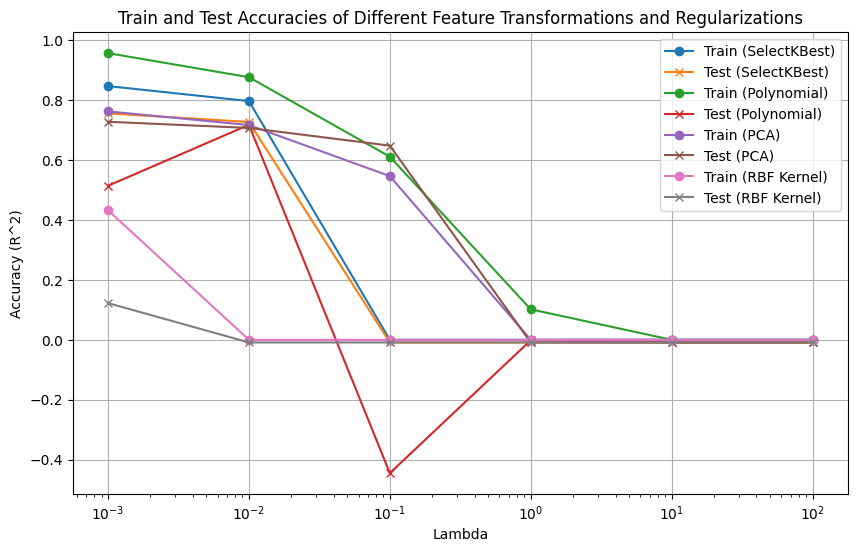

In [ ]:
# store results for plotting
transformations = ['SelectKBest', 'Polynomial', 'PCA', 'RBF Kernel']
lambdas = [0.001, 0.01, 0.1, 1, 10, 100]
train_accuracies = []
test_accuracies = []

# iterate through the transformations and lambdas
for transformation in transformations:
    for lambd in lambdas:
        # select transformation
        if transformation == 'SelectKBest':
            X_train_transformed = X_train_kbest
            X_val_transformed = X_val_kbest
            X_test_transformed = X_test_kbest
        elif transformation == 'Polynomial':
            poly = PolynomialFeatures(degree=3, include_bias=False)
            X_train_transformed = poly.fit_transform(X_train_kbest)
            X_val_transformed = poly.transform(X_val_kbest)
            X_test_transformed = poly.transform(X_test_kbest)
        elif transformation == 'PCA':
            pca = PCA(n_components=30)
            X_train_transformed = pca.fit_transform(X_train)
            X_val_transformed = pca.transform(X_val)
            X_test_transformed = pca.transform(X_test)
        elif transformation == 'RBF Kernel':
            rbf = RBFSampler(gamma=1, random_state=42, n_components=100)
            X_train_transformed = rbf.fit_transform(X_train_kbest)
            X_val_transformed = rbf.transform(X_val_kbest)
            X_test_transformed = rbf.transform(X_test_kbest)

        # apply Lasso regularization with lambda
        model = Lasso(alpha=lambd, max_iter=10000)
        model.fit(X_train_transformed, y_train)
        
        # get train and test accuracies (R^2 score)
        train_accuracy = model.score(X_train_transformed, y_train)
        test_accuracy = model.score(X_test_transformed, y_test)
        
        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)

# plot train and test accuracies
plt.figure(figsize=(10, 6))
for i, transformation in enumerate(transformations):
    plt.plot(lambdas, train_accuracies[i*len(lambdas):(i+1)*len(lambdas)], label=f'Train ({transformation})', marker='o')
    plt.plot(lambdas, test_accuracies[i*len(lambdas):(i+1)*len(lambdas)], label=f'Test ({transformation})', marker='x')

plt.xscale('log')
plt.xlabel('Lambda')
plt.ylabel('Accuracy (R^2)')
plt.title('Train and Test Accuracies of Different Feature Transformations and Regularizations')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# final evaluation on test set using best model from validation set
# best model: polynomial transformation + lasso regularization + lamda = 0.01
best_transformation = X_train_poly
best_val_transformation = X_val_poly
best_test_transformation = poly.transform(X_test_kbest)
best_model = Lasso(alpha=0.001, max_iter=10000)

best_model.fit(best_transformation, y_train)
y_test_pred = best_model.predict(best_test_transformation)
final_mse = mean_squared_error(y_test, y_test_pred)
final_r2 = best_model.score(best_test_transformation, y_test)
print("final test MSE:", final_mse)
print("final test R^2:", final_r2)

final test MSE: 0.007711434898825137
final test R^2: 0.5145167564468249


# Logistic Regression
Binary Classification
* Target variable - Position: Midfielder or Forward (Position_Midfielder)
* Features - Jersey Number,Club,Nationality,Age,Wins,Losses,Goals per match,Shots,Shots on target,Shooting accuracy %,Hit woodwork,Big chances missed,Clean sheets,Goals conceded,Tackles,Tackle success %,Last man tackles,Blocked shots,Interceptions,Clearances,Headed Clearance,Clearances off line,Recoveries,Duels won,Duels lost,Successful 50/50s,Aerial battles won,Aerial battles lost,Own goals,Errors leading to goal,Assists,Passes,Passes per match,Big chances created,Crosses,Cross accuracy %,Through balls,Accurate long balls, Yellow cards,Red cards,Fouls,Offsides

Data Preprocessing

In [ ]:
# read data into a pandas dataframe
df = pd.read_csv("epl_dataset.csv")

# remove players that have had less than 19 appearances (half of a season)
df = df[df['Appearances'] >= 19]

# remove features that are not useful for the model/too similar to target variable
df = df.drop(['Name', 'Goals', 'Appearances', 'Headed goals', 'Goals with right foot', 'Goals with left foot',
            'Penalties scored', 'Freekicks scored'], axis=1)

# remove goalkeepers and defenders
df = df[~df['Position'].isin(['Goalkeeper', 'Defender'])]

# dummy variable encode the position, club, and nationality columns
df = pd.get_dummies(df, columns=['Position', 'Club', 'Nationality',], drop_first=True, dtype=int)

# list of columns that contain percentages
percentage_columns = ['Shooting accuracy %', 'Cross accuracy %', 'Tackle success %']
# convert all percentage columns to decimal values (0 to 1)
for column in percentage_columns:
    df[column] = df[column].str.replace('%', '').astype(float) / 100

# fill any missing values with 0
df.fillna(0, inplace=True)

# replace values greater than 1 in the goals per match column with 0
df['Goals per match'] = df['Goals per match'].apply(lambda x: 0 if x > 1 else x)

# save the modified dataset
df.to_csv("epl_data_logistic_processed.csv", index=False)

No Regularization penalty or feature transformation

In [29]:
df = df = pd.read_csv("epl_data_logistic_processed.csv")
df = df.drop(columns=['Saves', 'Penalties saved', 'Punches', 'High Claims', 'Catches', 'Sweeper clearances', 'Throw outs', 'Goal Kicks'])

X = df.drop(columns= ['Position_Midfielder'])
y = df['Position_Midfielder']

# split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=42)

# scale dataset
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# define model
logreg = LogisticRegression(penalty=None, random_state=42)
logreg.fit(X_train, y_train)

y_train_pred = logreg.predict(X_train)
y_test_pred = logreg.predict(X_test)

train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print("Training Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)

Training Accuracy: 1.0
Test Accuracy: 0.9454545454545454


L1 Regularization

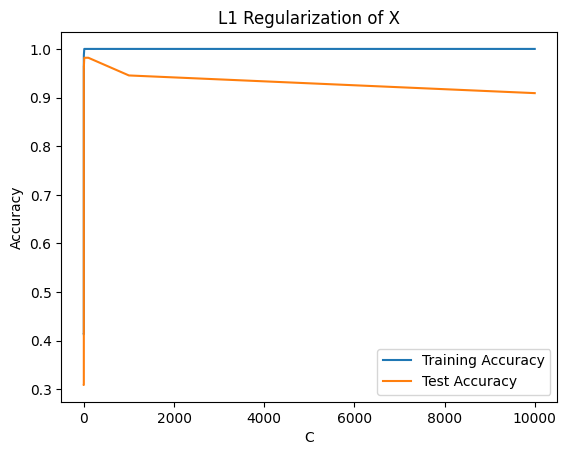

In [30]:
df = df = pd.read_csv("epl_data_logistic_processed.csv")
df = df.drop(columns=['Saves', 'Penalties saved', 'Punches', 'High Claims', 'Catches', 'Sweeper clearances', 'Throw outs', 'Goal Kicks'])

X = df.drop(columns= ['Position_Midfielder'])
y = df['Position_Midfielder']

# split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=42)

# scale dataset
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# define model
c_val = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
train = []
test = []

for i in range(len(c_val)):
  logreg = LogisticRegression(penalty='l1', solver='liblinear', C=c_val[i])
  logreg.fit(X_train, y_train)
  y_train_pred = logreg.predict(X_train)
  y_test_pred = logreg.predict(X_test)
  train.append(accuracy_score(y_train, y_train_pred))
  test.append(accuracy_score(y_test, y_test_pred))

plt.title('L1 Regularization of X')
plt.plot(c_val, train, label='Training Accuracy')
plt.plot(c_val, test, label='Test Accuracy')
plt.legend()
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.show()

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Training Accuracy: [0.9876543209876543, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Test Accuracy: [0.9454545454545454, 0.9454545454545454, 0.9272727272727272, 0.9090909090909091, 0.9272727272727272, 0.8909090909090909, 0.9090909090909091, 0.8545454545454545, 0.8363636363636363, 0.8181818181818182]


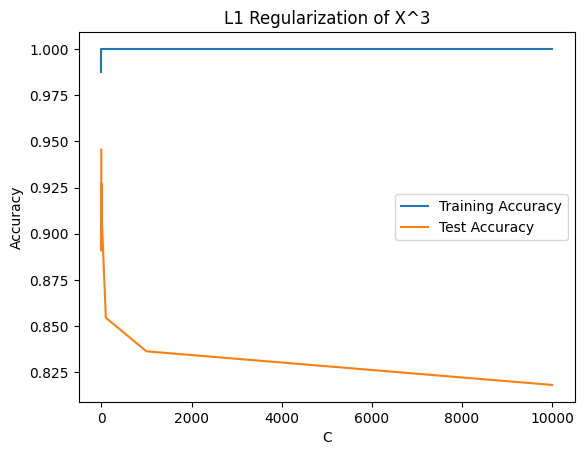

In [31]:
# transform x to degree 2 and 3
df = df = pd.read_csv("epl_data_logistic_processed.csv")
df = df.drop(columns=['Saves', 'Penalties saved', 'Punches', 'High Claims', 'Catches', 'Sweeper clearances', 'Throw outs', 'Goal Kicks'])

X = df.drop(columns= ['Position_Midfielder'])
y = df['Position_Midfielder']

# split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=42)

# transform features
poly = PolynomialFeatures(degree=3)
X_train = poly.fit_transform(X_train)
X_test = poly.transform(X_test)

# define model
c_val = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
train = []
test = []

for i in range(len(c_val)):
  logreg = LogisticRegression(penalty='l1', solver='liblinear', C=c_val[i])
  logreg.fit(X_train, y_train)
  y_train_pred = logreg.predict(X_train)
  y_test_pred = logreg.predict(X_test)
  train.append(accuracy_score(y_train, y_train_pred))
  test.append(accuracy_score(y_test, y_test_pred))

print("Training Accuracy:", train)
print("Test Accuracy:", test)

plt.title('L1 Regularization of X^3')
plt.plot(c_val, train, label='Training Accuracy')
plt.plot(c_val, test, label='Test Accuracy')
plt.legend()
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.show()

L2 Regularization

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

Training Accuracy: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Test Accuracy: [0.9636363636363636, 0.9818181818181818, 0.9818181818181818, 0.9818181818181818, 0.9818181818181818, 0.9818181818181818, 0.9818181818181818, 0.9818181818181818, 0.9818181818181818, 0.9818181818181818]


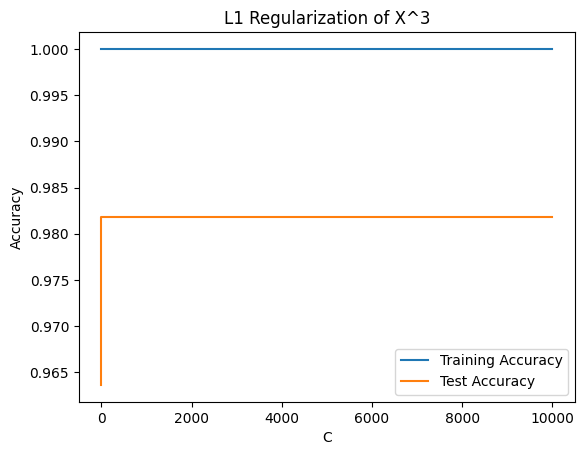

In [32]:
# transform x to degree 2 and 3
df = df = pd.read_csv("epl_data_logistic_processed.csv")
df = df.drop(columns=['Saves', 'Penalties saved', 'Punches', 'High Claims', 'Catches', 'Sweeper clearances', 'Throw outs', 'Goal Kicks'])

X = df.drop(columns= ['Position_Midfielder'])
y = df['Position_Midfielder']

# split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=42)

# transform features
poly = PolynomialFeatures(degree=3)
X_train = poly.fit_transform(X_train)
X_test = poly.transform(X_test)

# define model
c_val = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
train = []
test = []

for i in range(len(c_val)):
  logreg = LogisticRegression(penalty='l2', random_state=42, C=c_val[i])
  logreg.fit(X_train, y_train)
  y_train_pred = logreg.predict(X_train)
  y_test_pred = logreg.predict(X_test)
  train.append(accuracy_score(y_train, y_train_pred))
  test.append(accuracy_score(y_test, y_test_pred))

print("Training Accuracy:", train)
print("Test Accuracy:", test)

plt.title('L1 Regularization of X^3')
plt.plot(c_val, train, label='Training Accuracy')
plt.plot(c_val, test, label='Test Accuracy')
plt.legend()
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.show()

Training Accuracy: [0.5864197530864198, 0.5864197530864198, 0.9012345679012346, 0.9814814814814815, 0.9938271604938271, 1.0, 1.0, 1.0, 1.0, 1.0]
Test Accuracy: [0.6909090909090909, 0.6909090909090909, 0.8363636363636363, 0.9272727272727272, 0.9454545454545454, 0.9454545454545454, 0.9272727272727272, 0.9454545454545454, 0.9454545454545454, 0.9454545454545454]


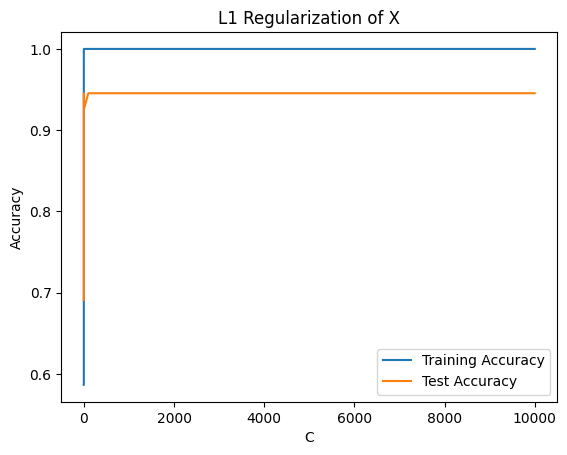

In [33]:
df = df = pd.read_csv("epl_data_logistic_processed.csv")
df = df.drop(columns=['Saves', 'Penalties saved', 'Punches', 'High Claims', 'Catches', 'Sweeper clearances', 'Throw outs', 'Goal Kicks'])

X = df.drop(columns= ['Position_Midfielder'])
y = df['Position_Midfielder']

# split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=42)

# scale dataset
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# define model
c_val = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
train = []
test = []

for i in range(len(c_val)):
  logreg = LogisticRegression(penalty='l2', random_state=42, C=c_val[i])
  logreg.fit(X_train, y_train)
  y_train_pred = logreg.predict(X_train)
  y_test_pred = logreg.predict(X_test)
  train.append(accuracy_score(y_train, y_train_pred))
  test.append(accuracy_score(y_test, y_test_pred))

print("Training Accuracy:", train)
print("Test Accuracy:", test)

plt.title('L1 Regularization of X')
plt.plot(c_val, train, label='Training Accuracy')
plt.plot(c_val, test, label='Test Accuracy')
plt.legend()
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.show()

# Neural Networks
Multi-class classification
* Target - Player Position: Goalkeeper, Defender, Midfielder, or Forward
* Features - Jersey Number,Club,Nationality,Age,Wins,Losses,Goals per match,Shots,Shots on target,Shooting accuracy %,Hit woodwork,Big chances missed,Clean sheets,Goals conceded,Tackles,Tackle success %,Last man tackles,Blocked shots,Interceptions,Clearances,Headed Clearance,Clearances off line,Recoveries,Duels won,Duels lost,Successful 50/50s,Aerial battles won,Aerial battles lost,Own goals,Errors leading to goal,Assists,Passes,Passes per match,Big chances created,Crosses,Cross accuracy %,Through balls,Accurate long balls, Yellow cards,Red cards,Fouls,Offsides

In [9]:
# read data into a pandas dataframe
df = pd.read_csv("epl_dataset.csv")

# remove the name column
df = df.drop(['Name'], axis=1)

# dummy variable encode the club and nationality columns
df = pd.get_dummies(df, columns=['Club', 'Nationality'], drop_first=True, dtype=int)

# specify the order of positions
position_order = ['Goalkeeper', 'Defender', 'Midfielder', 'Forward']
# one hot encode the position column in the specified order
df['Position'] = pd.Categorical(df['Position'], categories=position_order, ordered=True)
df = pd.get_dummies(df, columns=['Position'], drop_first=False, dtype=int)

# list of columns that contain percentages
percentage_columns = ['Shooting accuracy %', 'Cross accuracy %', 'Tackle success %']
# convert all percentage columns to decimal values (0 to 1)
for column in percentage_columns:
    df[column] = df[column].str.replace('%', '').astype(float) / 100

# fill any missing values with 0
df.fillna(0, inplace=True)

# replace values greater than 1 in the goals per match column with 0
df['Goals per match'] = df['Goals per match'].apply(lambda x: 0 if x > 1 else x)

# save the modified dataset
df.to_csv("epl_data_nn_processed.csv", index=False)

# separate features (X) and target (y)
X = df.drop(columns=['Position_Goalkeeper', 'Position_Defender', 'Position_Midfielder', 'Position_Forward'])
position_columns = [col for col in df.columns if col.startswith('Position_')]
y = df[position_columns].to_numpy()

# scale the data using StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# print the shape of the scaled features and target
print("shape of X: ", X.shape)
print("shape of y: ", y.shape)

# split the data into training and test set.  60% training and %40 test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)

# feature selection using SelectKBest chi2
k_best = SelectKBest(chi2, k=50)  # select the top 50 features
X_train = k_best.fit_transform(X_train, y_train)
X_test = k_best.transform(X_test)

shape of X:  (571, 130)
shape of y:  (571, 4)


Activation function and its derivative

In [34]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def sigmoid_deriv(z):
    return sigmoid(z) * (1 - sigmoid(z))

def relu(z):
    return np.maximum(z, 0)

def relu_deriv(z):
    return np.where(z > 0, 1, 0)

def tanh(z):
    return np.tanh(z)

def tanh_deriv(z):
    return 1 - np.tanh(z)**2

Creating and initializing $W$, $b$, $\triangledown W$, $\triangledown b$

In [35]:
def setup_and_init_weights(nn_structure):
    W = {}
    b = {}
    for l in range(1, len(nn_structure)):
        W[l] = r.random_sample((nn_structure[l], nn_structure[l-1]))
        b[l] = r.random_sample((nn_structure[l],))
    return W, b

def init_tri_values(nn_structure):
    tri_W = {}
    tri_b = {}
    for l in range(1, len(nn_structure)):
        tri_W[l] = np.zeros((nn_structure[l], nn_structure[l-1]))
        tri_b[l] = np.zeros((nn_structure[l],))
    return tri_W, tri_b

Feed forward pass and compute $\delta$

In [36]:
def feed_forward(x, W, b):
    #a = {1: x} # create a dictionary for holding the a values for all levels
    a = {1: x.reshape(-1)}  # Ensure it's 1D
    z = { } # create a dictionary for holding the z values for all the layers
    for l in range(1, len(W) + 1): # for each layer
        node_in = a[l]
        z[l+1] = W[l].dot(node_in) + b[l]  # z^(l+1) = W^(l)*a^(l) + b^(l)
        a[l+1] = sigmoid(z[l+1]) # a^(l+1) = f(z^(l+1))
    return a, z

def calculate_out_layer_delta(y, a_out, z_out):
    # delta^(nl) = -(y_i - a_i^(nl)) * f'(z_i^(nl))
    return -(y-a_out) * sigmoid_deriv(z_out) 


def calculate_hidden_delta(delta_plus_1, w_l, z_l):
    # delta^(l) = (transpose(W^(l)) * delta^(l+1)) * f'(z^(l))
    return np.dot(np.transpose(w_l), delta_plus_1) * sigmoid_deriv(z_l)

Back Propogation Algorithm

In [15]:
def train_nn(nn_structure, X, y, iter_num=3000, alpha=0.25, lambd=0):
    W, b = setup_and_init_weights(nn_structure)
    cnt = 0
    N = len(y)
    avg_cost_func = []
    print('Starting gradient descent for {} iterations'.format(iter_num))
    while cnt < iter_num:
        if cnt%1000 == 0:
            print('Iteration {} of {}'.format(cnt, iter_num))
        tri_W, tri_b = init_tri_values(nn_structure)
        avg_cost = 0
        for i in range(N):
            delta = {}
            # perform the feed forward pass and return the stored a and z values, to be used in the gradient descent step
            a, z = feed_forward(X[i, :], W, b)
            # a, z = feed_forward(X.iloc[i, :].to_numpy(), W, b)
            # loop from nl-1 to 1 backpropagating the errors
            for l in range(len(nn_structure), 0, -1):
                if l == len(nn_structure):
                    delta[l] = calculate_out_layer_delta(y[i,:], a[l], z[l])
                    # add a regularization term
                    avg_cost += np.linalg.norm((y[i,:]-a[l]))
                else:
                    if l > 1:
                        delta[l] = calculate_hidden_delta(delta[l+1], W[l], z[l])
                    # triW^(l) = triW^(l) + delta^(l+1) * transpose(a^(l))
                    tri_W[l] += np.dot(delta[l+1][:,np.newaxis], np.transpose(a[l][:,np.newaxis])) # np.newaxis increase the number of dimensions
                    # trib^(l) = trib^(l) + delta^(l+1)
                    tri_b[l] += delta[l+1]
        reg_cost = 0
        for l in range(1, len(nn_structure)):
            reg_cost += np.sum(np.square(W[l]))
        avg_cost += (lambd / (2.0 * N)) * reg_cost
        # perform the gradient descent step for the weights in each layer
        for l in range(len(nn_structure) - 1, 0, -1):
            W[l] += -alpha * ((1.0 / N * tri_W[l]) + lambd * W[l])
            # W[l] += -alpha * (1.0/N * tri_W[l])
            b[l] += -alpha * (1.0/N * tri_b[l])
        # complete the average cost calculation
        avg_cost = 1.0/N * avg_cost
        avg_cost_func.append(avg_cost)
        cnt += 1
    return W, b, avg_cost_func


def predict_y(W, b, X, n_layers):
    N = X.shape[0]
    y = np.zeros((N,))
    for i in range(N):
        # a, z = feed_forward(X.iloc[i, :].to_numpy(), W, b)
        a, z = feed_forward(X[i, :], W, b)
        y[i] = np.argmax(a[n_layers])
    return y

Train and evaluate each configuration of activation functions and regularization values

In [ ]:
# train and evaluate the neural network for each configuration
def test_configuration(activation, activation_deriv, layers, lambd):
    global f, f_deriv
    f = activation
    f_deriv = activation_deriv

    # define the neural network structure dynamically
    input_layer_size = X_train.shape[1]
    nn_structure = [input_layer_size] + [20] * layers + [4]

    # train neural network
    W, b, avg_cost_func = train_nn(nn_structure, X_train, y_train, iter_num=3000, alpha=0.25, lambd=lambd)

    # test accuracy
    y_test_binary = np.argmax(y_test, axis=1)
    y_pred = predict_y(W, b, X_test, layers + 1)
    accuracy = accuracy_score(y_test_binary, y_pred) * 100
    return accuracy

results = []

# loop through configurations
activations = {
    "sigmoid": (sigmoid, sigmoid_deriv),
    "ReLU": (relu, relu_deriv),
    "tanh": (tanh, tanh_deriv)
}
layers_list = [1, 2, 3]
lambdas = [None, 0.001, 0.01, 0.1, 1, 10, 100]

for activation_name, (activation, activation_deriv) in activations.items():
    for layers in layers_list:
        for lambd in lambdas:
            accuracy = test_configuration(activation, activation_deriv, layers, lambd)
            results.append({
                "Activation": activation_name,
                "Layers": layers,
                "Lambda": lambd,
                "Accuracy": accuracy
            })

# export results
results_df = pd.DataFrame(results)
results_df.to_csv("nn_results.csv", index=False)

print("results saved to 'nn_results.csv'")

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000
Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000
Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000
Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000
Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000
Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000
Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000
Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000
Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 

Best model: sigmoid activation, 2 layers, no regularization

In [19]:
# dynamically set the input layer size based on the number of features in X_train_kbest
input_layer_size = X_train.shape[1]
nn_structure = [input_layer_size, 20, 4]

# train the NN
W, b, avg_cost_func = train_nn(nn_structure, X_train, y_train, 3000, 0.25)

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


Plot the average cost function

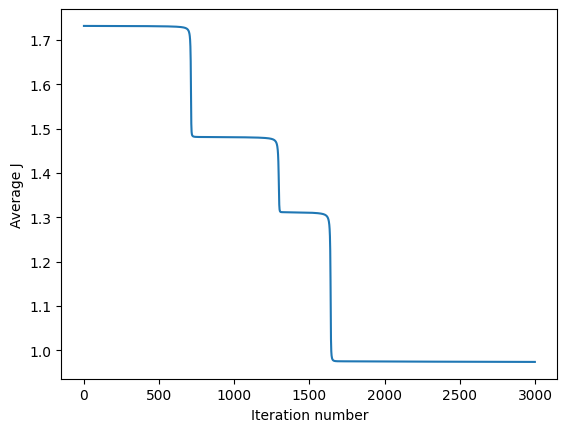

In [20]:
# plot the avg_cost_func
plt.plot(avg_cost_func)
plt.ylabel('Average J')
plt.xlabel('Iteration number')
plt.show()

Final predication accuracy

In [22]:
y_test_binary = np.argmax(y_test, axis=1)
y_pred = predict_y(W, b, X_test, 3)

# calculate the accuracy, precision, and recall
accuracy = accuracy_score(y_test_binary, y_pred) * 100
precision = precision_score(y_test_binary, y_pred, average='weighted', zero_division=0) * 100
recall = recall_score(y_test_binary, y_pred, average='weighted', zero_division=0) * 100

# print the results
print('Prediction accuracy is {:.2f}%'.format(accuracy))
print('Precision is {:.2f}%'.format(precision))
print('Recall is {:.2f}%'.format(recall))

Prediction accuracy is 34.06%
Precision is 11.60%
Recall is 34.06%
